<a href="https://colab.research.google.com/github/hvmdvvn/Pytorch-Projects/blob/main/Sarcasm_Detection_BERT_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hvmdvvn
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 548MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.drop(["article_link"], inplace=True, axis=1)
print(df.shape)
df.head()

(26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(df.headline),
    np.array(df.is_sarcastic),
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=42
)

print(X_train.shape[0], X_val.shape[0], X_test.shape[0])

18695 4006 4007


In [7]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = [tokenizer(x,
                        max_length = 100,
                        truncation = True,
                        padding = "max_length",
                        return_tensors = 'pt').to(device)
                        for x in X # Changed from X_test to X
              ]
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [27]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [28]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [29]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
class MyModel(nn.Module):
  def __init__(self, bert):
    super(MyModel, self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768, 384)
    self.linear2 = nn.Linear(384, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids, attention_mask, return_dict=False)[0][:,0]
    output = self.linear1(output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)

    return output

In [31]:
for param in bert_model.parameters():
  param.requires_grad = False

  model = MyModel(bert_model).to(device)

In [32]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [33]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [34]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for data in train_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


  # Validation
  with torch.no_grad():
    for indx, data in enumerate(val_loader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()
      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() * 100, 4))

  print(f'''
  Epoch No. {epoch+1},
  Train Loss: {round(total_loss_train/1000, 4)},
  Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}.
  Validation Loss: {round(total_loss_validation/1000, 4)},
  Validation Accuracy: {round(total_acc_validation/validation_data.__len__() * 100, 4)}
        ''')
  print('='*25)


  Epoch No. 1,
  Train Loss: 0.2591,
  Train Accuracy: 80.4172.
  Validation Loss: 0.0489,
  Validation Accuracy: 83.2751
        

  Epoch No. 2,
  Train Loss: 0.2103,
  Train Accuracy: 84.7446.
  Validation Loss: 0.0449,
  Validation Accuracy: 85.1722
        

  Epoch No. 3,
  Train Loss: 0.1983,
  Train Accuracy: 85.2634.
  Validation Loss: 0.0432,
  Validation Accuracy: 85.7464
        

  Epoch No. 4,
  Train Loss: 0.1917,
  Train Accuracy: 85.8037.
  Validation Loss: 0.0433,
  Validation Accuracy: 85.6216
        

  Epoch No. 5,
  Train Loss: 0.1863,
  Train Accuracy: 86.3332.
  Validation Loss: 0.042,
  Validation Accuracy: 86.67
        

  Epoch No. 6,
  Train Loss: 0.1832,
  Train Accuracy: 86.4884.
  Validation Loss: 0.0422,
  Validation Accuracy: 85.971
        

  Epoch No. 7,
  Train Loss: 0.1822,
  Train Accuracy: 86.5419.
  Validation Loss: 0.0413,
  Validation Accuracy: 86.5452
        

  Epoch No. 8,
  Train Loss: 0.1798,
  Train Accuracy: 86.7879.
  Validation Lo

In [35]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for indx, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_test += acc


print(f"Accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)} and Loss: {round(total_loss_test/1000, 4)}")

Accuracy: 85.5004 and Loss: 0.0421


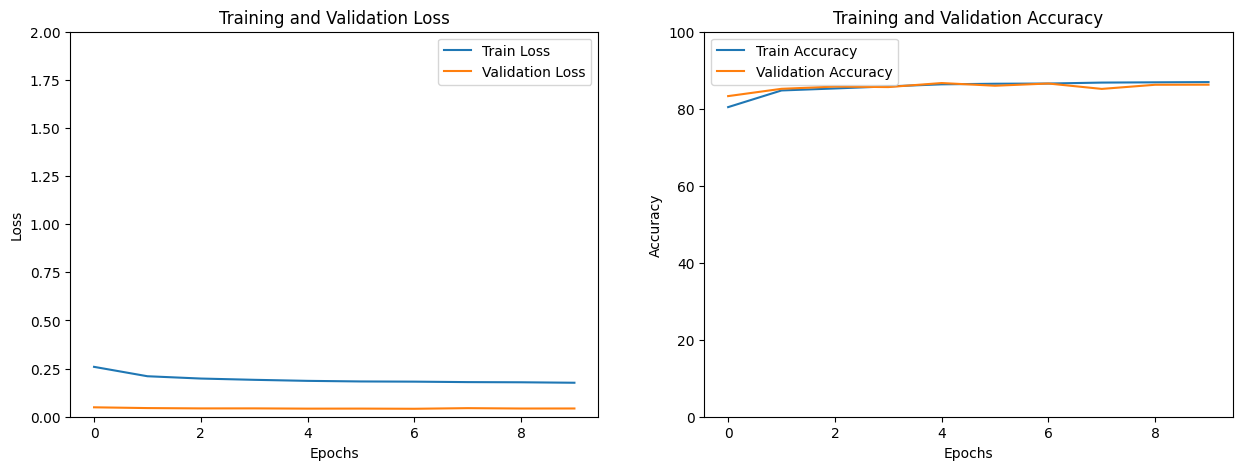

In [36]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'Train Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Train Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.show()